In [2]:
from max_reward_buffer import ReplayBuffer
import os
from energies import *
from plot_utils import *
from utils import set_seed, cal_subtb_coef_matrix, fig_to_image, get_gfn_optimizer, get_gfn_forward_loss, \
    get_gfn_backward_loss, get_exploration_std, get_name
    
from models import GFN

In [72]:
buffer = ReplayBuffer(600000, device='cuda', exploration_mode=True)

In [73]:
buffer.load_buffer('/home/uky/repos_python/Research/gfn-diffusion/final_training/25/buffer/many_well/buffer_8000_10000.npy')

In [74]:
buffer.set_prioritization()

In [37]:
energy_name = "many_well"

def get_energy(energy_name, device):
    if energy_name == '9gmm':
        energy = NineGaussianMixture(device=device)
    elif energy_name == '25gmm':
        energy = TwentyFiveGaussianMixture(device=device)
    elif energy_name == 'hard_funnel':
        energy = HardFunnel(device=device)
    elif energy_name == 'easy_funnel':
        energy = EasyFunnel(device=device)
    elif energy_name == 'many_well':
        energy = ManyWell(device=device)
    return energy

energy = get_energy(energy_name, 'cpu')

In [10]:
def plot_step(energy, energy_name,  samples, device = 'cpu'):

    # Visualization 및 파일 저장
    if energy_name == 'many_well':
        vizualizations = viz_many_well(energy, samples)
        fig_samples_x13, ax_samples_x13, fig_kde_x13, ax_kde_x13, fig_contour_x13, ax_contour_x13, fig_samples_x23, ax_samples_x23, fig_kde_x23, ax_kde_x23, fig_contour_x23, ax_contour_x23 = vizualizations

        fig_samples_x13.savefig(f'samplesx13.pdf', bbox_inches='tight')
        fig_samples_x23.savefig(f'samplesx23.pdf', bbox_inches='tight')

        fig_kde_x13.savefig(f'kdex13.pdf', bbox_inches='tight')
        fig_kde_x23.savefig(f'kdex23.pdf', bbox_inches='tight')

        fig_contour_x13.savefig(f'contourx13.pdf', bbox_inches='tight')
        fig_contour_x23.savefig(f'contourx23.pdf', bbox_inches='tight')

    else:
        fig_contour, ax_contour = get_figure(bounds=(-13., 13.))
        fig_kde, ax_kde = get_figure(bounds=(-13., 13.))
        fig_kde_overlay, ax_kde_overlay = get_figure(bounds=(-13., 13.))

        plot_contours(energy.log_reward, ax=ax_contour, bounds=(-13., 13.), n_contour_levels=150, device=device)
        plot_kde(samples, ax=ax_kde_overlay, bounds=(-13., 13.))
        plot_kde(samples, ax=ax_kde, bounds=(-13., 13.))
        plot_samples(samples, ax=ax_contour, bounds=(-13., 13.))
        plot_samples(samples, ax=ax_kde_overlay, bounds=(-13., 13.))

        fig_contour.savefig(f'contour.pdf', bbox_inches='tight')
        fig_kde_overlay.savefig(f'kde_overlay.pdf', bbox_inches='tight')
        fig_kde.savefig(f'kde.pdf', bbox_inches='tight')


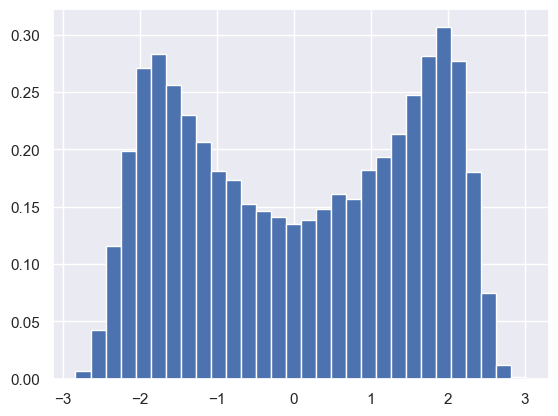

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min())




x = np.array(samples)[:, 30]
hist = plt.hist(x, bins=30, density = True)

In [75]:
samples, _ = buffer.sample(10000)

Minimum Reward in buffer:  -100


/tmp/ipykernel_682492/1239915438.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plot_step(energy, energy_name, torch.tensor(samples).to('cuda'))


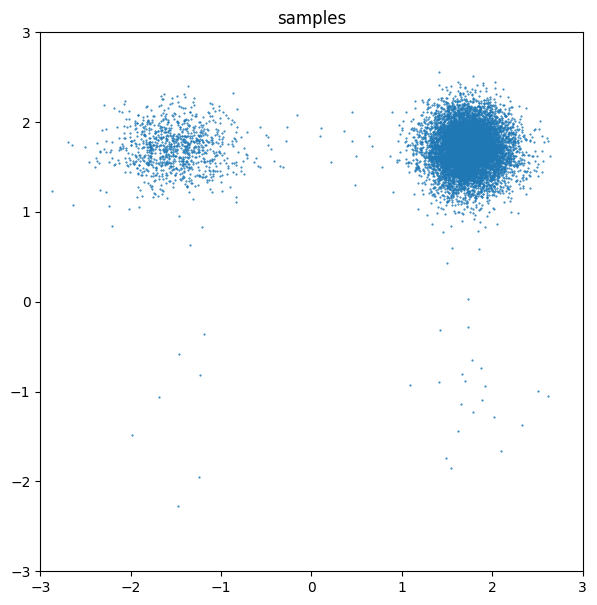

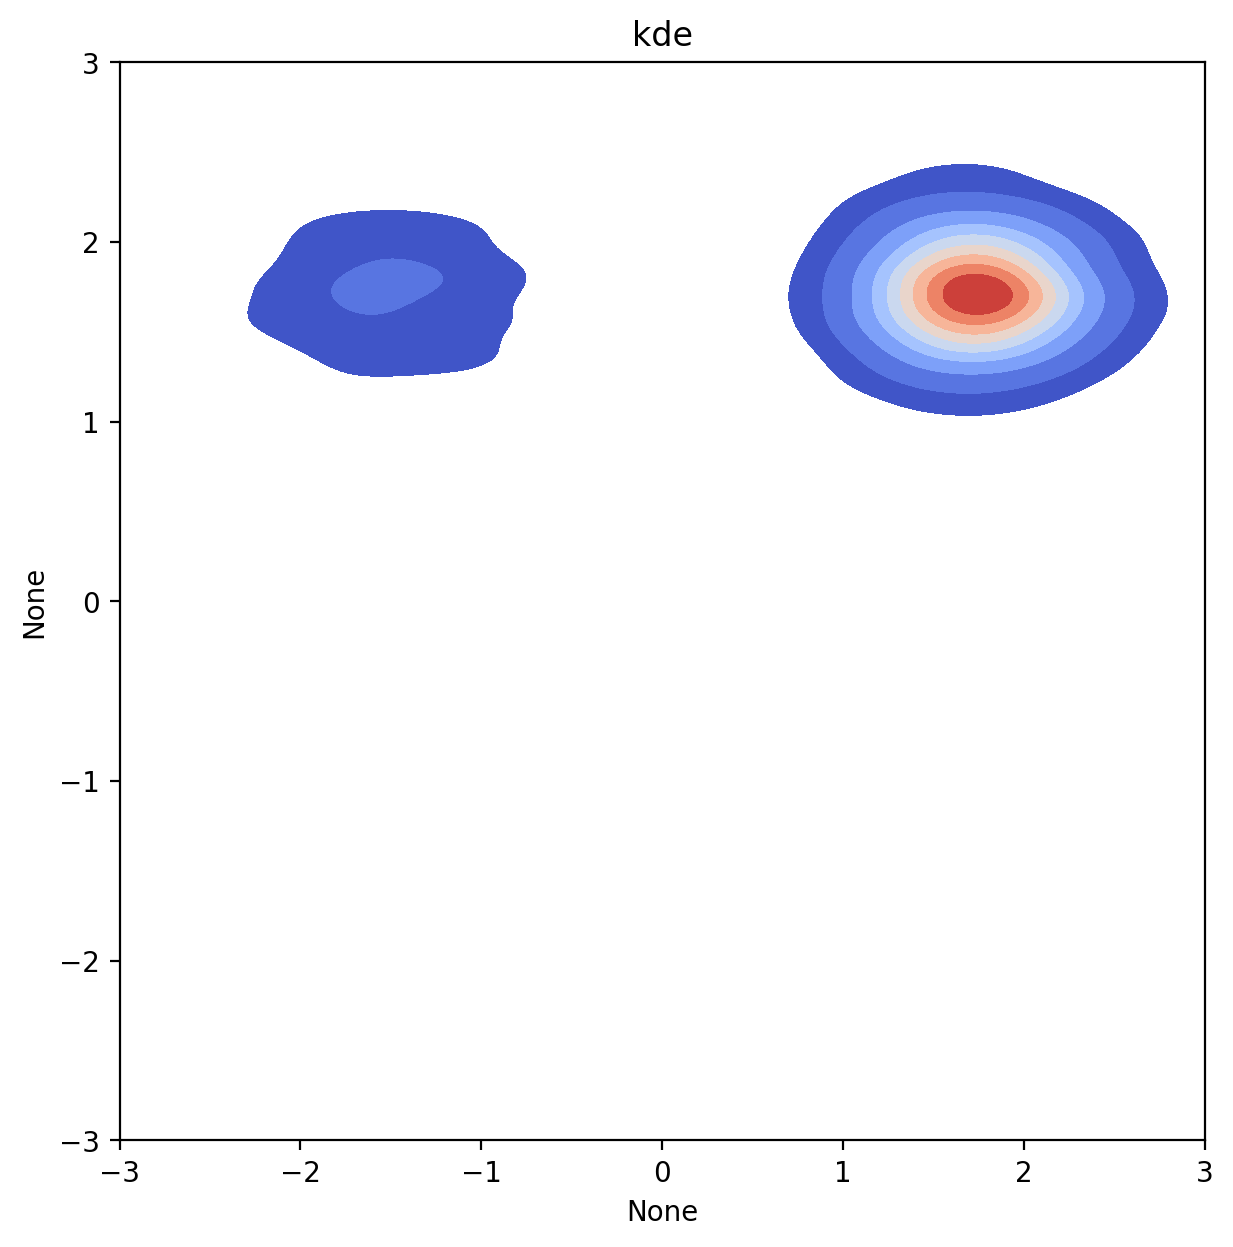

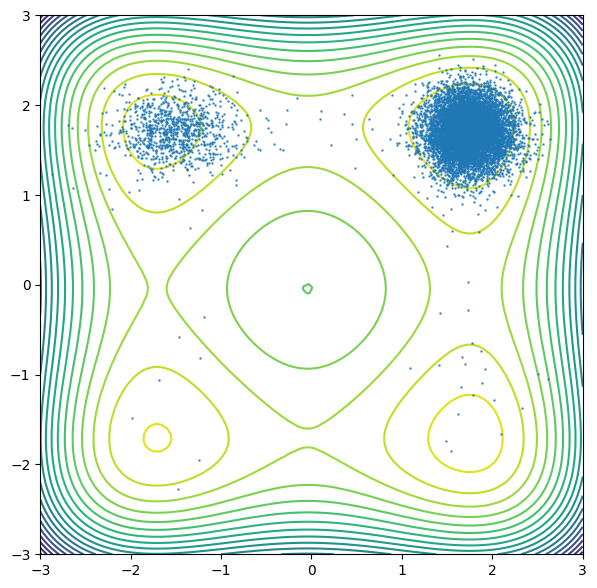

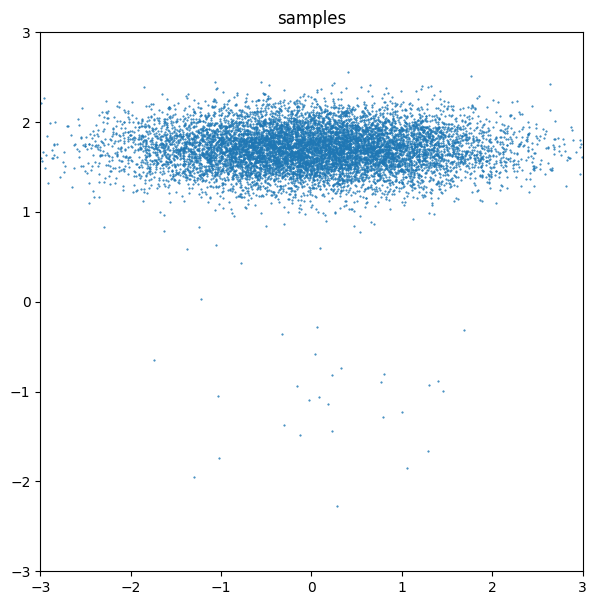

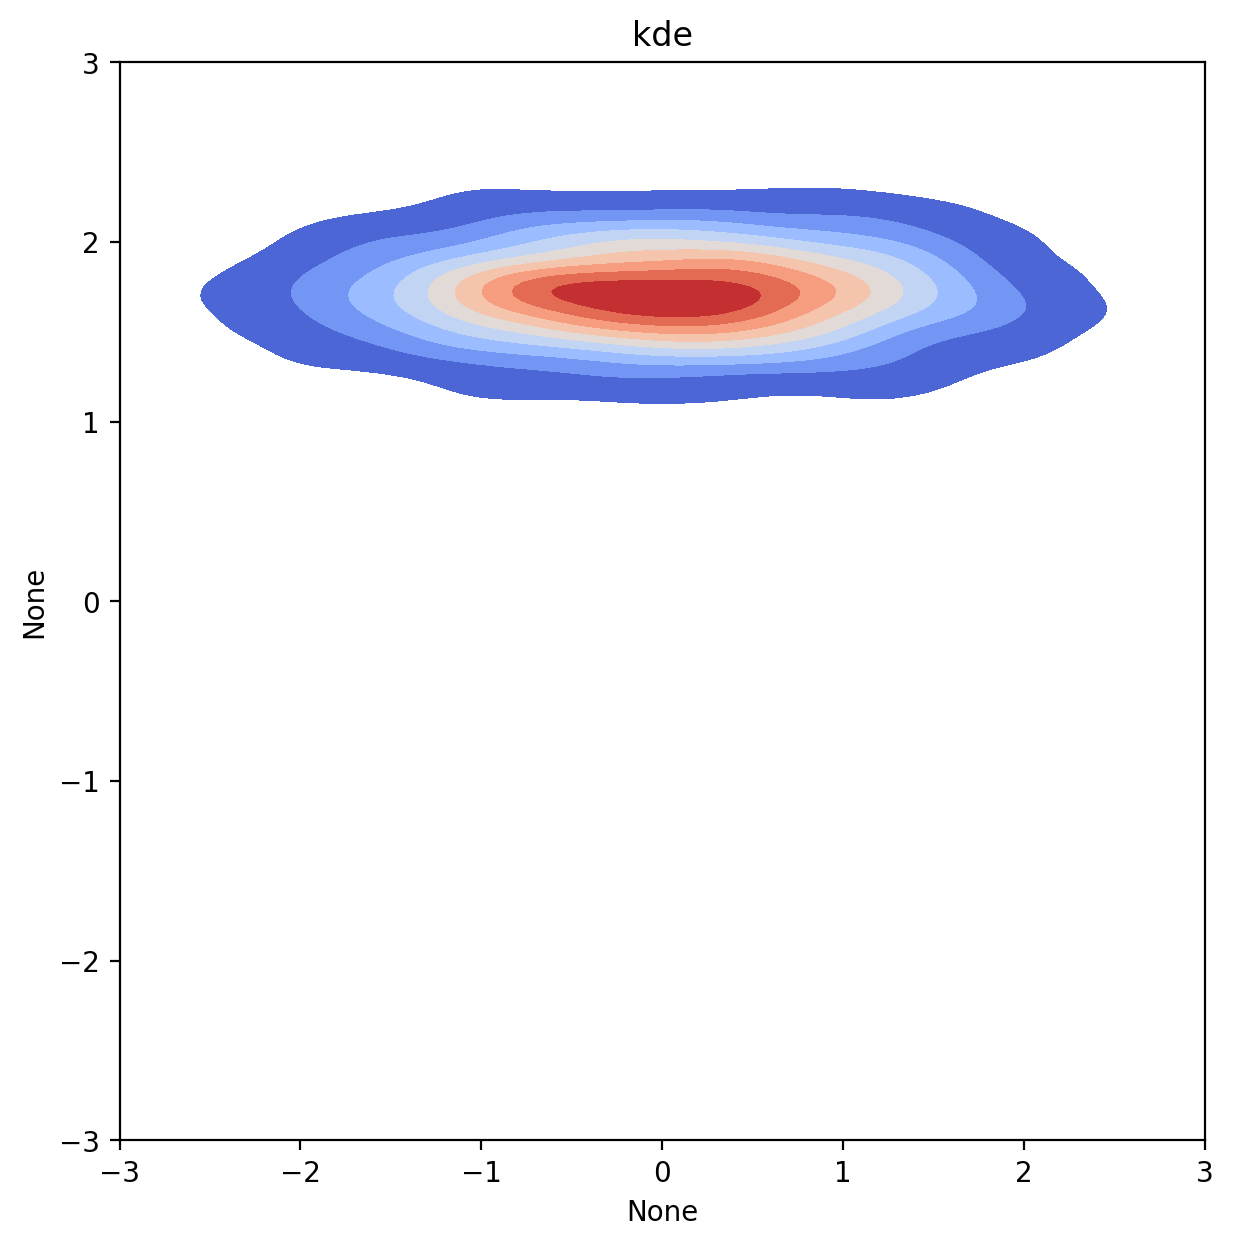

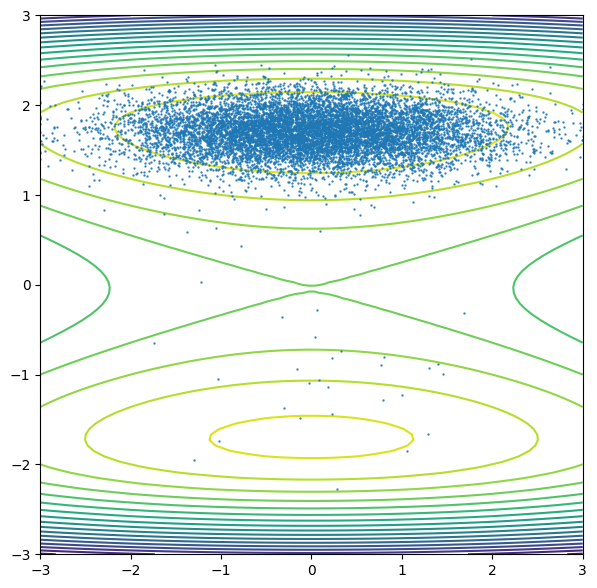

In [82]:
plot_step(energy, energy_name, torch.tensor(samples).to('cuda'))

In [60]:
# 기본값으로 argparse 파싱한 결과를 args 딕셔너리로 만드는 코드
args = {
    'lr_policy': 1e-3,
    'lr_flow': 1e-1,
    'lr_back': 1e-1,
    'hidden_dim': 64,
    's_emb_dim': 64,
    't_emb_dim': 64,
    'harmonics_dim': 64,
    'batch_size': 2000,
    'epochs': 25000,
    'buffer_size': 300 * 1000,
    'T': 100,
    'subtb_lambda': 2,
    't_scale': 1.,
    'log_var_range': 4.,
    'energy': 'many_well',
    'mode_fwd': 'tb',
    'mode_bwd': 'tb',
    'both_ways': False,
    'only_fwd': False,
    'only_bwd': False,
    'phase1': 15000,
    'phase2': 25000,
    'phase3': 25000,
    'phase2reset': False,
    'phase1_spreading': False,
    'local_search': False,
    'max_iter_ls': 200,
    'burn_in': 100,
    'ls_cycle': 100,
    'ld_step': 0.001,
    'ld_schedule': False,
    'target_acceptance_rate': 0.574,
    'load_buffer_path': None,
    'pr_or_co': 'prioritize',
    'bwd': False,
    'exploratory': False,
    'sampling': 'buffer',
    'langevin': False,
    'langevin_scaling_per_dimension': False,
    'conditional_flow_model': False,
    'learn_pb': False,
    'pb_scale_range': 0.1,
    'learned_variance': False,
    'partial_energy': False,
    'exploration_factor': 0.0,
    'exploration_wd': False,
    'clipping': True,
    'lgv_clip': 1e2,
    'gfn_clip': 1e4,
    'zero_init': True,
    'pis_architectures': True,
    'lgv_layers': 3,
    'joint_layers': 2,
    'seed': 12345,
    'weight_decay': 1e-7,
    'use_weight_decay': False,
    'eval': False,
    'device': 'cuda:0',
    'load_model_path': None,
    'wandb': False
}

# args 딕셔너리가 정상적으로 생성된 것을 확인할 수 있습니다.
import pprint
pprint.pprint(args)


{'T': 100,
 'batch_size': 2000,
 'both_ways': False,
 'buffer_size': 300000,
 'burn_in': 100,
 'bwd': False,
 'clipping': True,
 'conditional_flow_model': False,
 'device': 'cuda:0',
 'energy': 'many_well',
 'epochs': 25000,
 'eval': False,
 'exploration_factor': 0.0,
 'exploration_wd': False,
 'exploratory': False,
 'gfn_clip': 10000.0,
 'harmonics_dim': 64,
 'hidden_dim': 64,
 'joint_layers': 2,
 'langevin': False,
 'langevin_scaling_per_dimension': False,
 'ld_schedule': False,
 'ld_step': 0.001,
 'learn_pb': False,
 'learned_variance': False,
 'lgv_clip': 100.0,
 'lgv_layers': 3,
 'load_buffer_path': None,
 'load_model_path': None,
 'local_search': False,
 'log_var_range': 4.0,
 'lr_back': 0.1,
 'lr_flow': 0.1,
 'lr_policy': 0.001,
 'ls_cycle': 100,
 'max_iter_ls': 200,
 'mode_bwd': 'tb',
 'mode_fwd': 'tb',
 'only_bwd': False,
 'only_fwd': False,
 'partial_energy': False,
 'pb_scale_range': 0.1,
 'phase1': 15000,
 'phase1_spreading': False,
 'phase2': 25000,
 'phase2reset': False,


In [61]:
def initialize_GFN(energy, args, device):
    # if args= dict
    gfn_model = GFN(energy.data_ndim, args['s_emb_dim'], args['hidden_dim'], args['harmonics_dim'], args['t_emb_dim'],

                    trajectory_length=args['T'], clipping=args['clipping'], lgv_clip=args['lgv_clip'], gfn_clip=args['gfn_clip'],
                    langevin=args['langevin'], learned_variance=args['learned_variance'],
                    partial_energy=args['partial_energy'], log_var_range=args['log_var_range'],
                    pb_scale_range=args['pb_scale_range'],
                    t_scale=args['t_scale'], langevin_scaling_per_dimension=args['langevin_scaling_per_dimension'],
                    conditional_flow_model=args['conditional_flow_model'], learn_pb=args['learn_pb'],
                    pis_architectures=args['pis_architectures'], lgv_layers=args['lgv_layers'],
                    joint_layers=args['joint_layers'], zero_init=args['zero_init'], device=device).to(device)
    gfn_optimizer = get_gfn_optimizer(gfn_model, args['lr_policy'], args['lr_flow'], args['lr_back'], args['learn_pb'],
                                    args['conditional_flow_model'], args['use_weight_decay'], args['weight_decay'])
    return gfn_model, gfn_optimizer

In [62]:
gfn_model, gfn_optimizer = initialize_GFN(energy, args, 'cuda')

In [80]:
# Load model
gfn_model.load_state_dict(torch.load('/home/uky/repos_python/Research/gfn-diffusion/final_training/33/model_many_well_25000_phase2.pt'),strict= False)

/tmp/ipykernel_682492/4236598260.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gfn_model.load_state_dict(torch.load('/home/uky/repos_python/Research/gfn-diffusion/fina

<All keys matched successfully>

In [81]:
samples = gfn_model.sample(10000, energy.log_reward)